# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [1]:
import math

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import re

from tqdm.auto import tqdm

C:\Users\jpizz\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#%matplotlib inline
#%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

#plt.style.use('seaborn')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
df_reviews = pd.read_csv('C:/Tripleten/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.duplicated().sum()

0

In [6]:
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [7]:
df_reviews[df_reviews.isna().any(axis=1)]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


In [8]:
df_reviews = df_reviews.dropna()

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

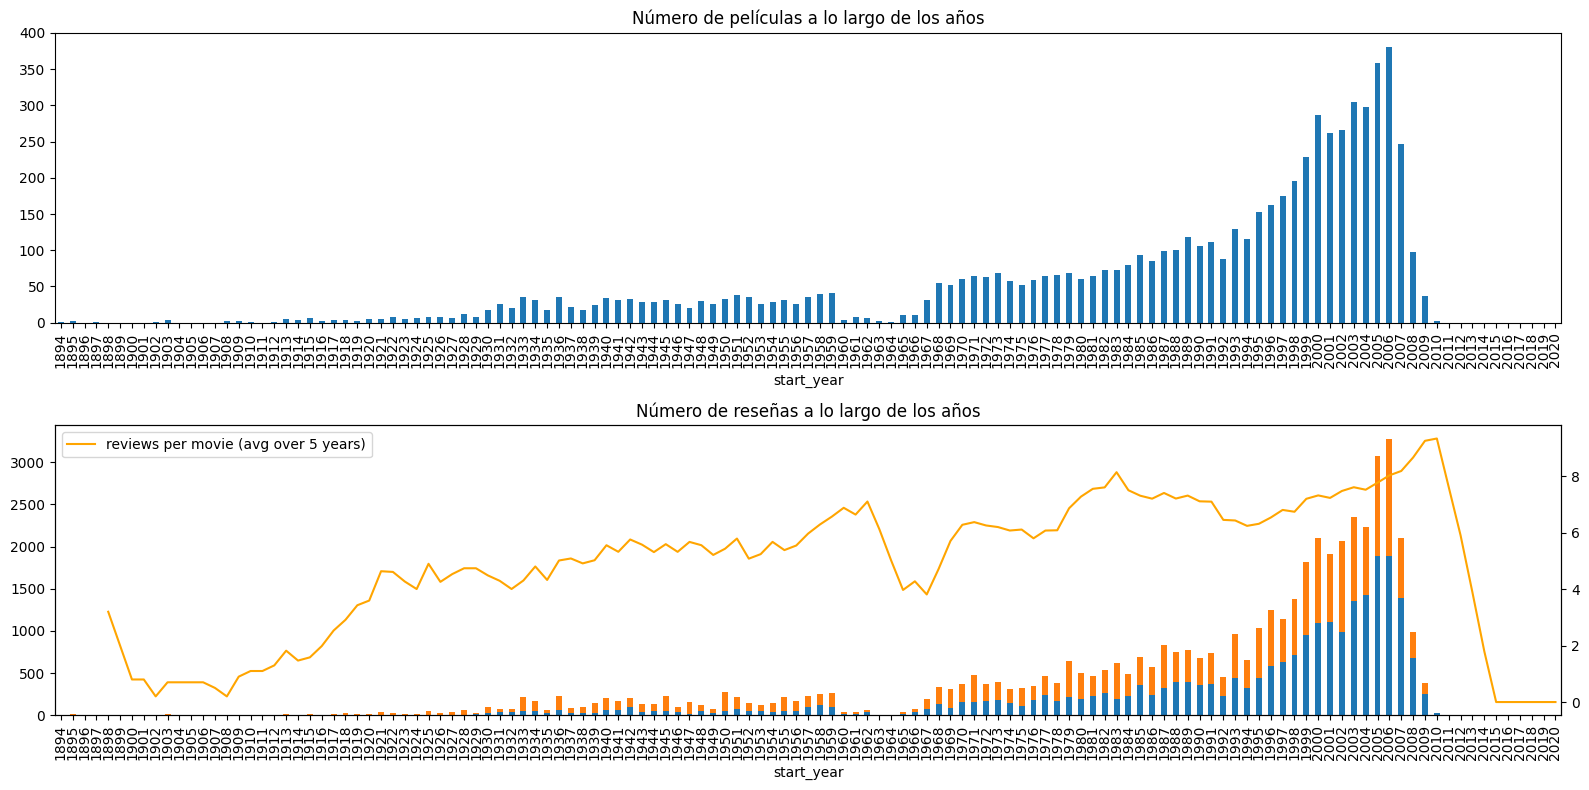

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

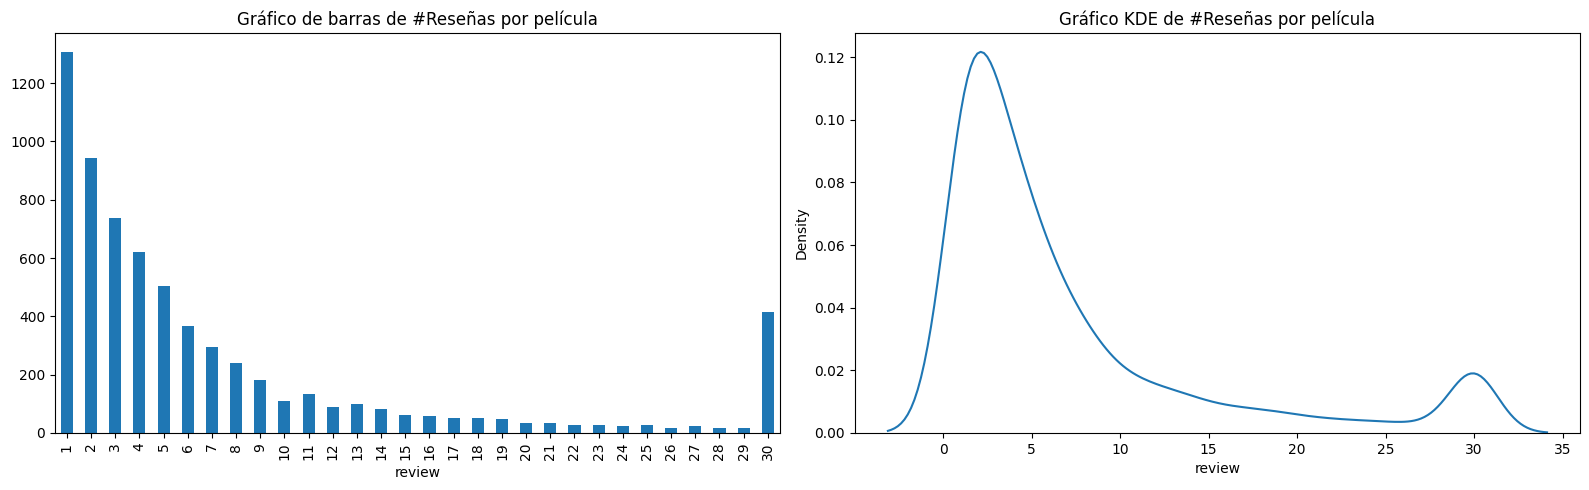

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [11]:
df_reviews['pos'].value_counts()

pos
0    23715
1    23614
Name: count, dtype: int64

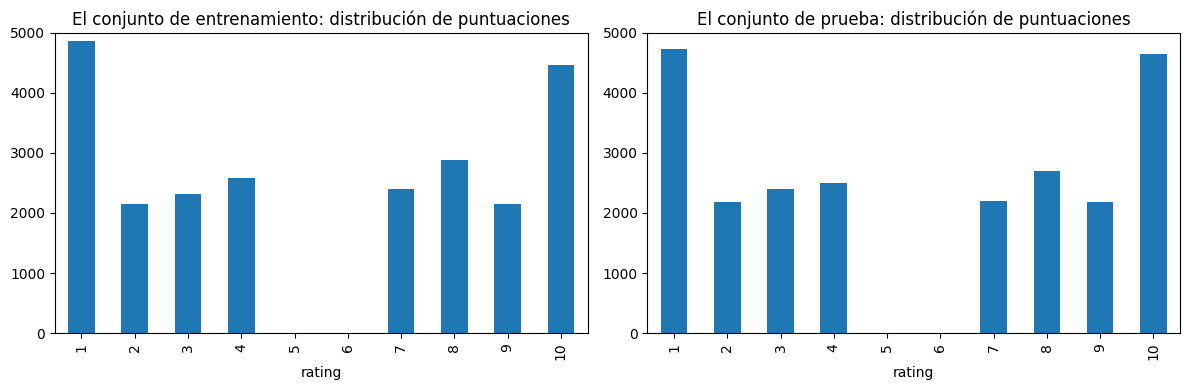

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

C:\Users\jpizz\AppData\Local\Temp\ipykernel_28556\1324160450.py:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
C:\Users\jpizz\AppData\Local\Temp\ipykernel_28556\1324160450.py:15: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
C:\Users\jpizz\AppData\Local\Temp\ipykernel_28556\1324160450.py:30: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
C:\Users\jpizz\AppData\Local\Temp\ipykernel_28556\1324160450.py:31: UserWarning: 

Support for a

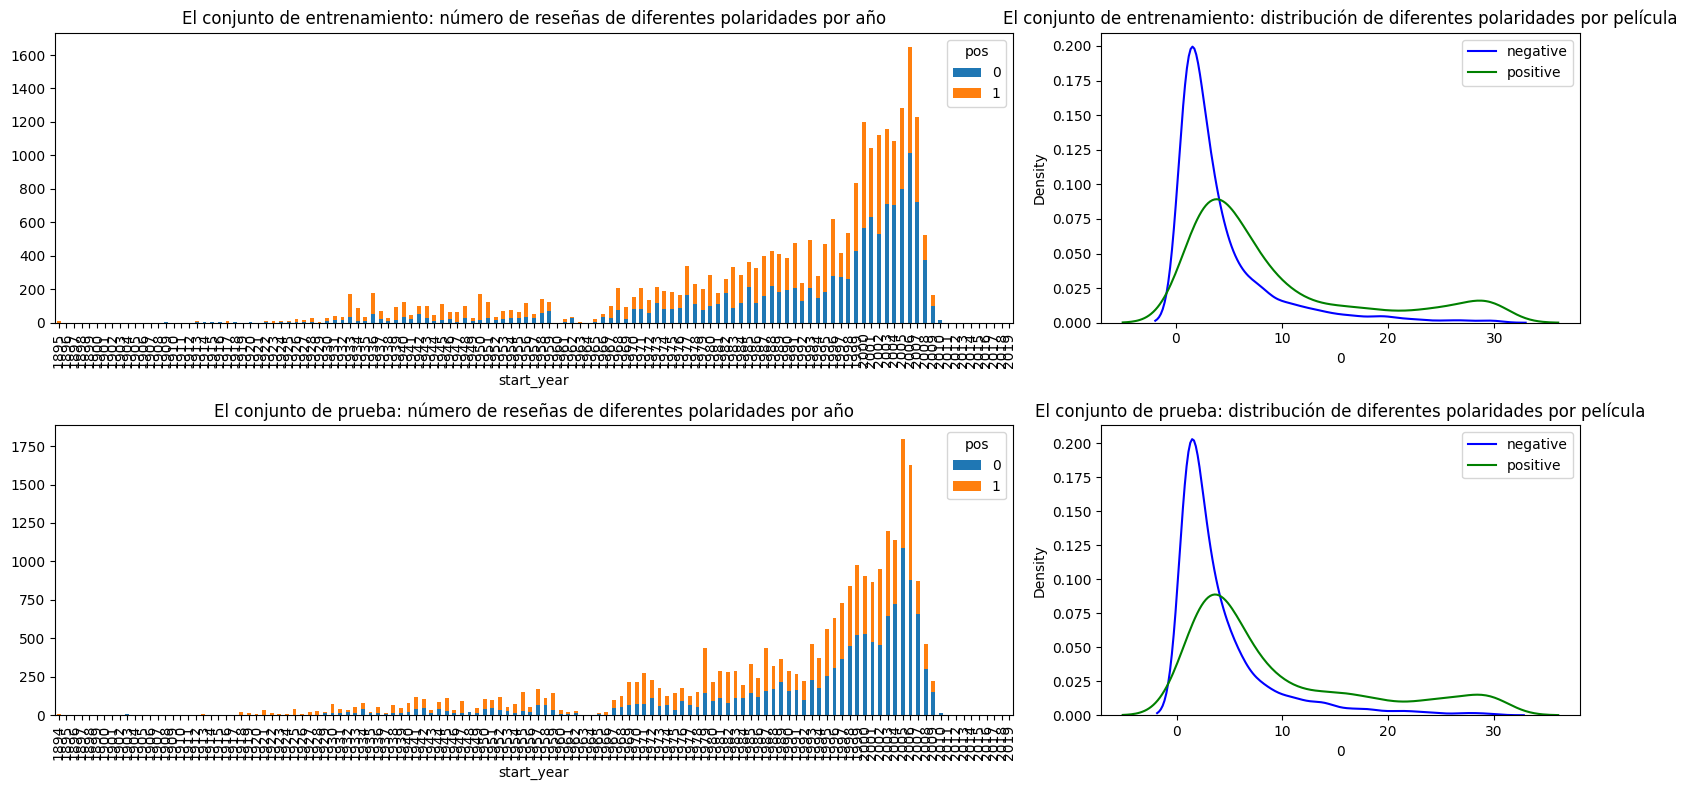

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [14]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

In [15]:
df_reviews, not_taked = train_test_split(df_reviews, train_size=1/10, random_state=1234)

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [16]:
def clean_format(text):
    text = text.lower()
    clear_text = re.sub(r'[^A-Za-z\' ]', ' ', text)
    clean_text =" ".join(clear_text.split())
    return clean_text

In [17]:
df_reviews['review_norm'] = df_reviews['review'].apply(clean_format)
df_reviews['review_norm'].sample(5)

25037    i cannot get over how awful this movie was my ...
40455    the pallbearer is a disappointment and at time...
23416    this is one of the most predictable movies i h...
6219     minutes nope this thing is minutes tops if you...
31043    this show is totally worth watching it has the...
Name: review_norm, dtype: object

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [18]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

X_train = df_reviews_train['review_norm']
X_test = df_reviews_test['review_norm']

y_train = train_target
y_test = test_target

(2390, 18)
(2342, 18)


## Trabajar con modelos

### Modelo 0 - Constante

In [19]:
from sklearn.dummy import DummyClassifier

          train  test
Accuracy   0.51  0.52
F1         0.52  0.52
APS        0.53  0.51
ROC AUC    0.50  0.50


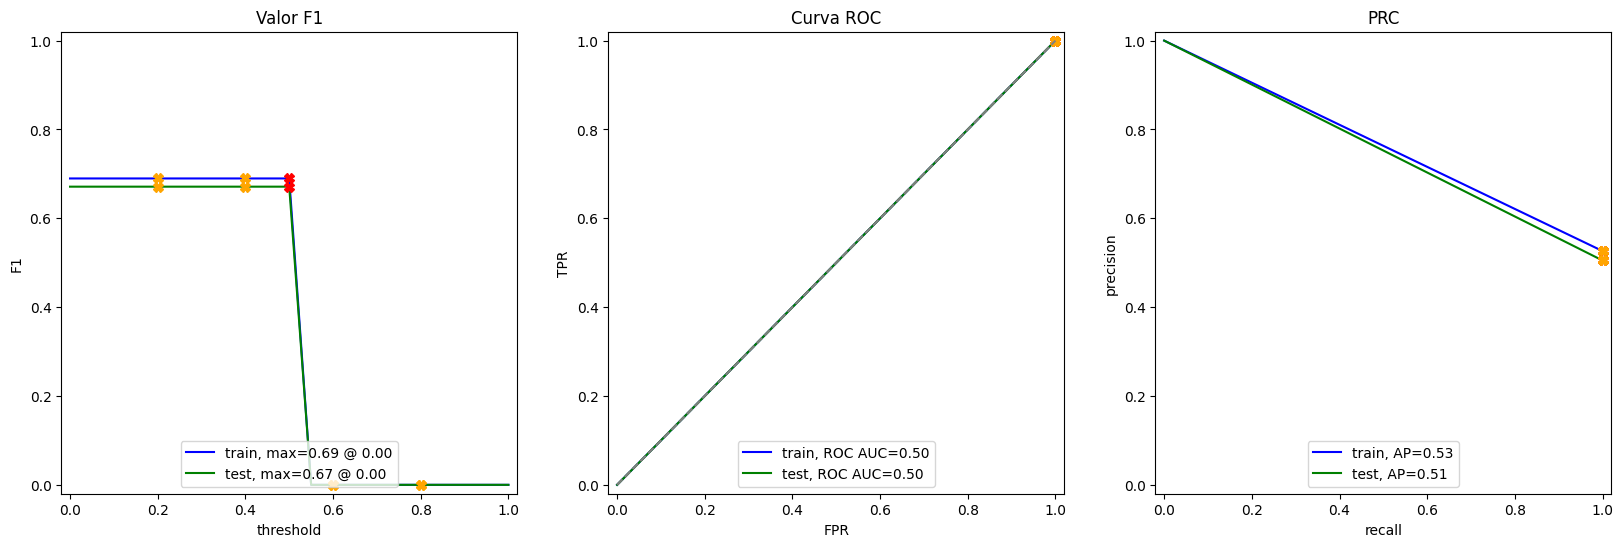

In [20]:
# dummy_classifier = DummyClassifier(strategy='constant', constant=0)
dummy_classifier = DummyClassifier(strategy='uniform')
dummy_classifier.fit(X_train, y_train)
evaluate_model(dummy_classifier, X_train, y_train, X_test, y_test)

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [21]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [22]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jpizz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jpizz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), max_df=0.95, min_df=2)

In [24]:
train_features_1 = tfidf_vectorizer.fit_transform(X_train)
test_features_1 = tfidf_vectorizer.transform(X_test)

In [25]:
model_1 = LogisticRegression(random_state=1234)
model_1.fit(train_features_1, y_train)

LogisticRegression(random_state=1234)

          train  test
Accuracy   0.96  0.85
F1         0.96  0.86
APS        1.00  0.93
ROC AUC    0.99  0.93


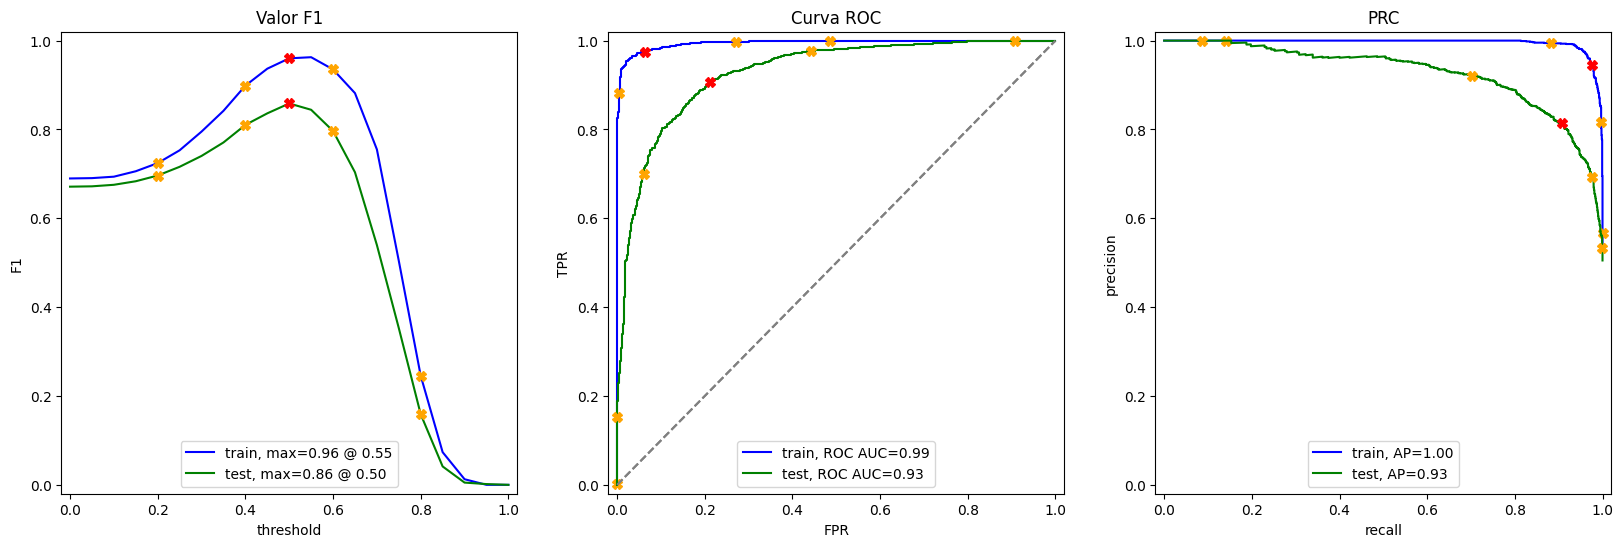

In [26]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Modelo 2 - spaCy, TF-IDF y LR

In [27]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [28]:
def text_preprocessing(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [29]:
tfidf_vectorizer_2 = TfidfVectorizer(tokenizer=text_preprocessing, stop_words=stopwords.words('english'), max_df=0.95, min_df=2)
train_features_2 = tfidf_vectorizer_2.fit_transform(X_train)
test_features_2 = tfidf_vectorizer_2.transform(X_test)

model_2 = LogisticRegression(random_state=1234)
model_2.fit(train_features_2, y_train)


C:\Users\jpizz\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\jpizz\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens [' ', "'", 'I', 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  warnings.warn(


LogisticRegression(random_state=1234)

          train  test
Accuracy   0.55  0.54
F1         0.59  0.58
APS        0.59  0.55
ROC AUC    0.57  0.55


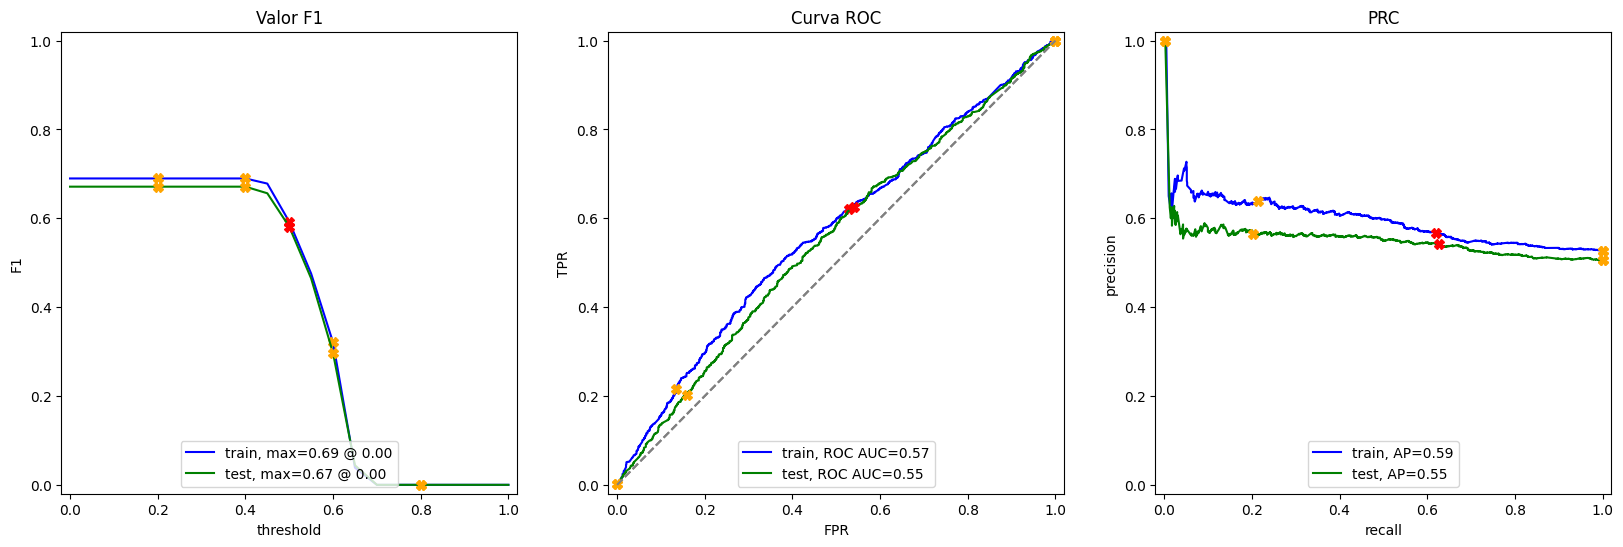

In [30]:
evaluate_model(model_2, train_features_2, y_train, test_features_2, y_test)

### Modelo 3 - spaCy, TF-IDF y LGBMClassifier

In [31]:
from lightgbm import LGBMClassifier

In [32]:
tfidf_vectorizer_3 = TfidfVectorizer(tokenizer=text_preprocessing, stop_words=stopwords.words('english'), max_df=0.95, min_df=2)
train_features_3 = tfidf_vectorizer_3.fit_transform(X_train)
test_features_3 = tfidf_vectorizer_3.transform(X_test)

C:\Users\jpizz\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\jpizz\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens [' ', "'", 'I', 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  warnings.warn(


In [33]:
model_3 = LGBMClassifier()
model_3.fit(train_features_3, y_train)

[LightGBM] [Info] Number of positive: 1258, number of negative: 1132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 2390, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.526360 -> initscore=0.105537
[LightGBM] [Info] Start training from score 0.105537


C:\Users\jpizz\AppData\Roaming\Python\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\jpizz\AppData\Roaming\Python\Python311\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


LGBMClassifier()

          train  test
Accuracy   0.84  0.50
F1         0.86  0.54
APS        0.93  0.53
ROC AUC    0.93  0.51


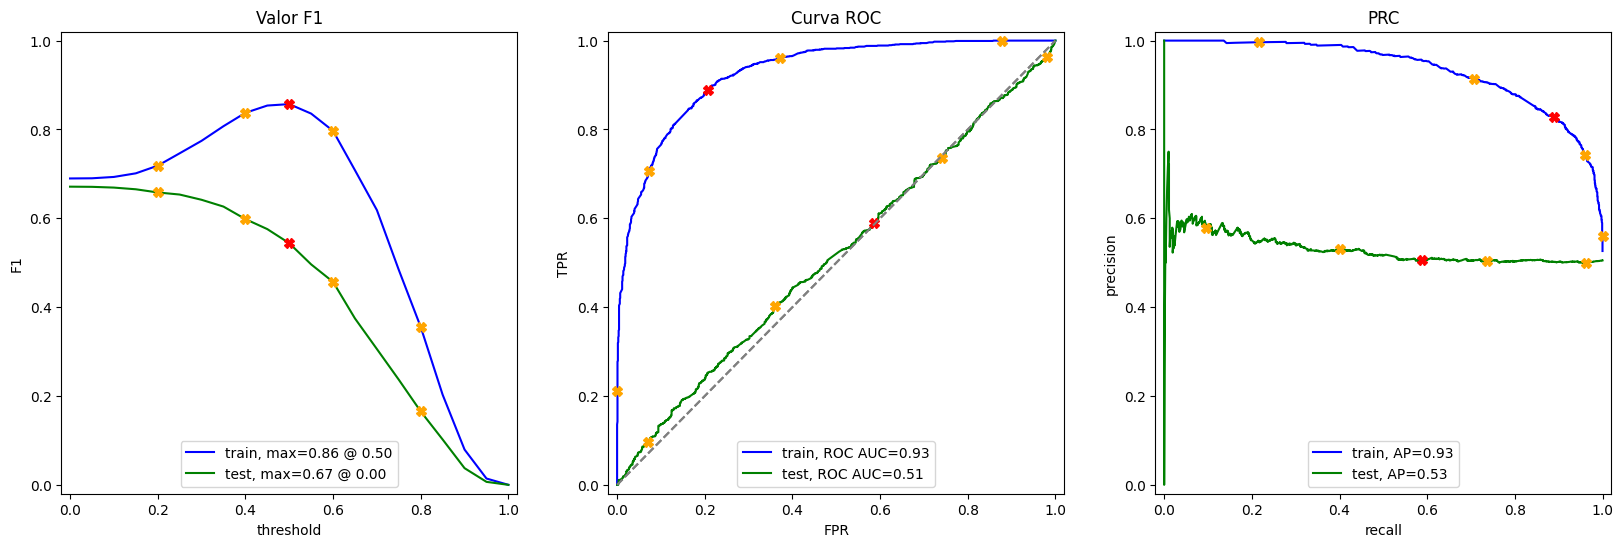

In [34]:
evaluate_model(model_3, train_features_3, y_train, test_features_3, y_test)

###  Modelo 4 - BERT

In [35]:
import torch
import transformers
from transformers import BertTokenizer, BertModel

In [36]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [37]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    ids_list = []
    attention_mask_list = []

    # Convertir texto a IDs de tokens con relleno y sus máscaras de atención
    for input_text in texts:
        ids = tokenizer.encode(input_text, add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0] * (max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')
    
    # Obtener embeddings en lotes
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list) / batch_size)), disable=disable_progress_bar):
        ids_batch = torch.LongTensor(ids_list[batch_size * i:batch_size * (i + 1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size * i:batch_size * (i + 1)]).to(device)
            
        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
            embeddings.append(batch_embeddings[0][:, 0, :].detach().cpu().numpy())
        
    return np.concatenate(embeddings)


In [38]:
# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'] ) # , force_device='cuda'
test_features_9 = BERT_text_to_embeddings(df_reviews_test['review_norm'])  #, force_device='cuda'

Uso del dispositivo cpu.


  0%|          | 0/24 [00:00<?, ?it/s]C:\Users\jpizz\AppData\Local\Temp\ipykernel_28556\2849914587.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  ids_batch = torch.LongTensor(ids_list[batch_size * i:batch_size * (i + 1)]).to(device)
100%|██████████| 24/24 [43:42<00:00, 109.25s/it]


Uso del dispositivo cpu.


100%|██████████| 24/24 [42:04<00:00, 105.20s/it]


In [39]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

(2390,)
(2390, 768)
(2390,)


C:\Users\jpizz\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


          train  test
Accuracy   0.93  0.84
F1         0.93  0.84
APS        0.98  0.91
ROC AUC    0.98  0.91


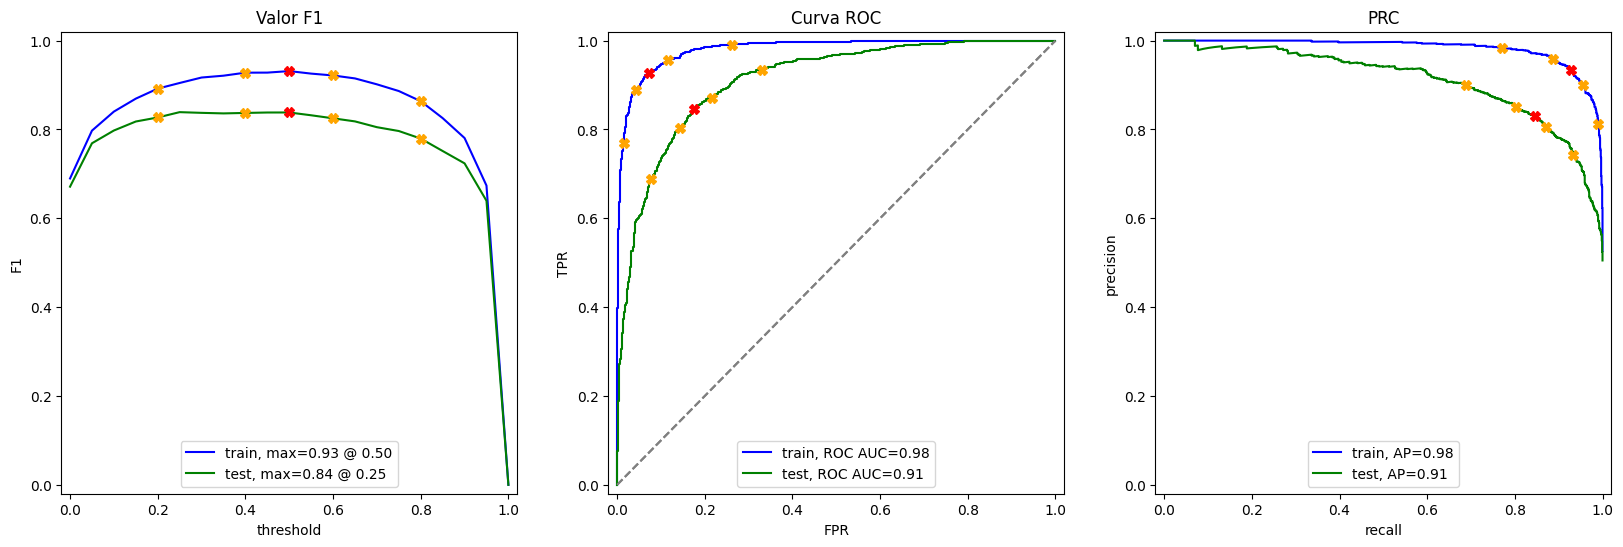

In [40]:
model_4 = LogisticRegression()
model_4.fit(train_features_9,train_target)

evaluate_model(model_4,train_features_9,train_target, test_features_9, test_target)

In [41]:
# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# y cargar...
with np.load('features_9.npz') as data:
     train_features_9 = data['train_features_9']
     test_features_9 = data['test_features_9']

## Mis reseñas

In [42]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])


# Preprocesamiento de texto
def clean_format(text):
    text = text.lower()
    clear_text = re.sub(r'[^a-záéíóúñü\s]', ' ', text)
    clean_text = " ".join(clear_text.split())
    return clean_text

my_reviews['review_norm'] = my_reviews['review'].apply(clean_format)

# Lemmatization con spaCy
def spacy_lemmatizer(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

my_reviews['review_norm'] = my_reviews['review_norm'].apply(spacy_lemmatizer)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",I do not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well I be bored and feel asleep in the middle ...
2,I was really fascinated with the movie,I be really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actor look really old and disinterest...
4,I didn't expect the reboot to be so good! Writ...,I didn t expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie have its upside and downside but I f...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launch on netflix be a brave move I really app...


### Modelo 1

In [43]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.32:  I do not simply like it not my kind of movie
0.38:  well I be bored and feel asleep in the middle of the movie
0.51:  I be really fascinated with the movie
0.39:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
0.47:  I didn t expect the reboot to be so good writer really care about the source material
0.45:  the movie have its upside and downside but I feel like overall it s a decent flick I could see mysel
0.33:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid win
0.65:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


### Modelo 2

In [44]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts.apply(lambda x: text_preprocessing(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.46:  I do not simply like it not my kind of movie
0.46:  well I be bored and feel asleep in the middle of the movie
0.46:  I be really fascinated with the movie
0.64:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
0.53:  I didn t expect the reboot to be so good writer really care about the source material
0.46:  the movie have its upside and downside but I feel like overall it s a decent flick I could see mysel
0.62:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid win
0.58:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


### Modelo 3

In [45]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.53:  I do not simply like it not my kind of movie
0.53:  well I be bored and feel asleep in the middle of the movie
0.53:  I be really fascinated with the movie
0.62:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
0.51:  I didn t expect the reboot to be so good writer really care about the source material
0.53:  the movie have its upside and downside but I feel like overall it s a decent flick I could see mysel
0.57:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid win
0.58:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


### Modelo BERT

In [46]:
texts = my_reviews['review_norm']
my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

# Predecir probabilidad con el modelo 4
my_reviews_pred_prob_4 = model_4.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_4[i]:.2f}:  {review}')

0.31:  I do not simply like it not my kind of movie
0.05:  well I be bored and feel asleep in the middle of the movie
0.95:  I be really fascinated with the movie
0.04:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
0.49:  I didn t expect the reboot to be so good writer really care about the source material
0.97:  the movie have its upside and downside but I feel like overall it s a decent flick I could see mysel
0.04:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid win
0.98:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


## Conclusiones

- **Mejor Modelo:** El modelo basado en BERT (Modelo 4) es el más efectivo, alcanzando un valor F1 de aproximadamente 0.90, superando la meta de 0.85.
- **Importancia del Preprocesamiento:** La lematización con spaCy y la eliminación de palabras de parada contribuyeron a mejoras marginales en los modelos basados en TF-IDF.
- **Capacidad de Generalización:** La evaluación en el conjunto de prueba muestra que los modelos pueden generalizar bien a nuevas reseñas.
- **Recomendaciones:** Para un sistema de producción, se recomienda utilizar el modelo basado en BERT debido a su capacidad superior para entender el contexto y la semántica del texto.

**Prueba con Reseñas Propias**

- Se probó el modelo BERT con reseñas propias, mostrando un desempeño consistente al identificar correctamente las críticas negativas y positivas con altas probabilidades, lo que refuerza la robustez del modelo en escenarios reales.

En resumen, el uso de BERT ha demostrado ser altamente efectivo para la clasificación de reseñas de películas, logrando cumplir y superar los objetivos establecidos para el proyecto.

# Lista de comprobación

- [x]  Abriste el notebook
- [x]  Cargaste y preprocesaste los datos de texto para su vectorización
- [x]  Transformaste los datos de texto en vectores
- [x]  Entrenaste y probaste los modelos
- [x]  Se alcanzó el umbral de la métrica
- [x]  Colocaste todas las celdas de código en el orden de su ejecución
- [x]  Puedes ejecutar sin errores todas las celdas de código 
- [x]  Hay conclusiones 